
# LAB 3: Feature Detection and Matching

1. What are features?

  To analyze and classify images, it is necessary to extract relevant features from the pixels. These features can include textures, shapes, colors, etc., which are often transformed into vectors of numerical descriptors.

  - Corners: Detected by Harris, FAST, and SIFT.
  - Edges: Often detected using Canny or Sobel as preprocessing steps, though SIFT also uses edge information.
  - Blobs: Detected by SIFT, SURF, KAZE, AKAZE, and MSER.
2. Implement Haris corner detection.
3. Implement SIFT (Scale-Invariant Feature Transform).
4. Implement custom sequential model such as VGG for feature extraction.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# 1. Haris corner detection

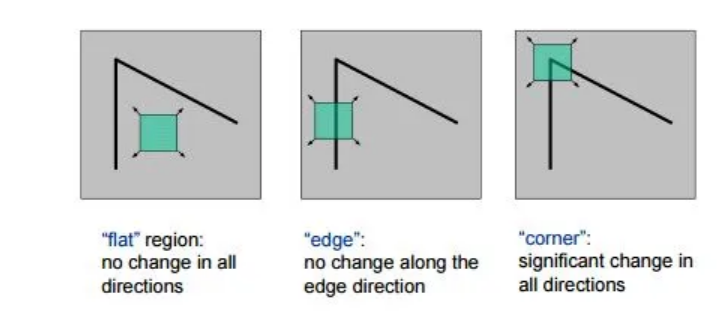

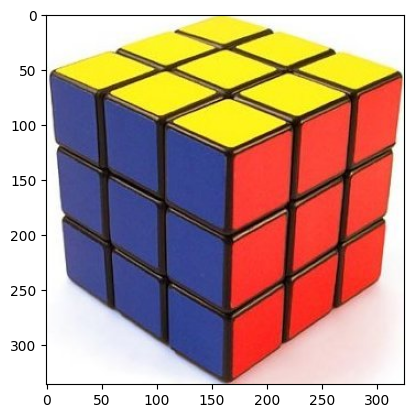

In [ ]:
# Read in the image
image = cv2.imread('./imgA.jpg')

# Make a copy of the image
image_Copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_Copy, cv2.COLOR_BGR2RGB)

plt.imshow(image_copy)

Detect the corners

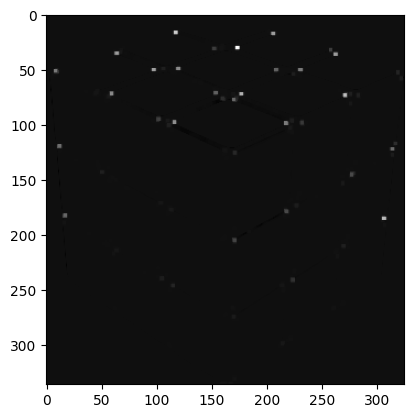

In [ ]:
# Convert to grayscale
gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)

# Detect corners
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# Dilate corner image to enhance corner points
dst = cv2.dilate(dst,None)

plt.imshow(dst, cmap='gray')


Extract and display strong corners

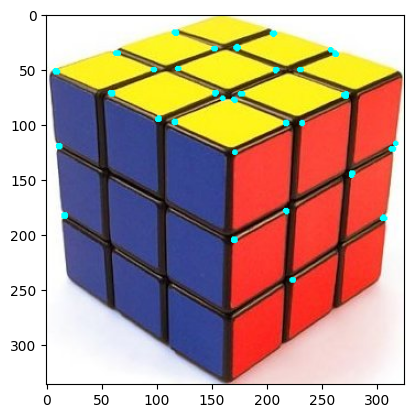

In [ ]:
# This value vary depending on the image and how many corners you want to detect
# Try changing this free parameter, 0.1, to be larger or smaller and see what happens
threshold = 0.1*dst.max()

# Create an image copy to draw corners on
corner_image = np.copy(image_copy)

# Iterate through all the corners and draw them on the image (if they pass the threshold)
for j in range(0, dst.shape[0]):
    for i in range(0, dst.shape[1]):
        if(dst[j,i] > threshold):
            # image, center pt, radius, color, thickness
            cv2.circle( corner_image, (i, j), 1, (0,255,255), 1)

plt.imshow(corner_image)

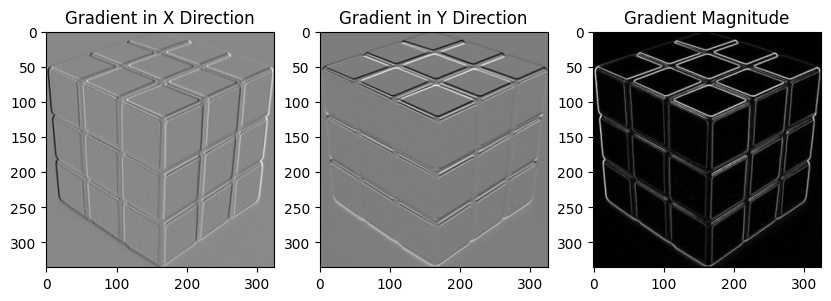

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image and convert to grayscale
image = cv2.imread('./imgA.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute gradients using Sobel operator
grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in X direction
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in Y direction

# Compute gradient magnitude
magnitude = np.sqrt(grad_x**2 + grad_y**2)

# Normalize magnitude for visualization
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Gradient in X Direction")
plt.imshow(grad_x, cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Gradient in Y Direction")
plt.imshow(grad_y, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Gradient Magnitude")
plt.imshow(magnitude, cmap='gray')
plt.show()


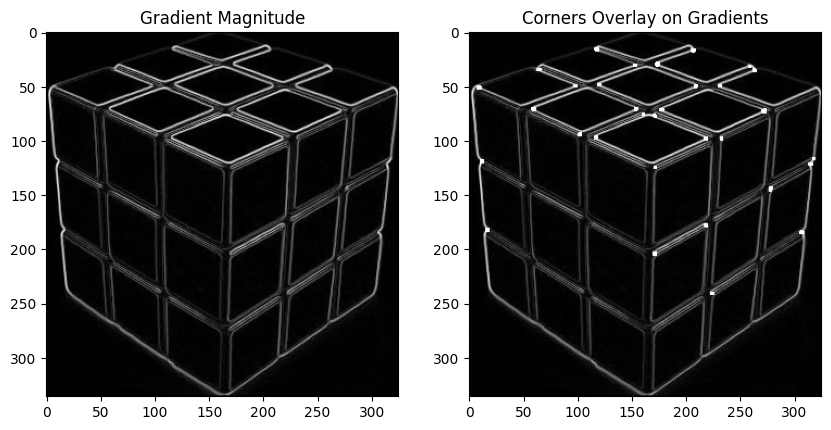

In [ ]:
# Detect corners using Harris corner detection
dst = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
dst = cv2.dilate(dst, None)

# Threshold to find strong corners
threshold = 0.1 * dst.max()
corners = dst > threshold

# Create a copy of the gradient magnitude to overlay corners
overlay = np.copy(magnitude)
overlay[corners] = 255  # Highlight corners

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Gradient Magnitude")
plt.imshow(magnitude, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Corners Overlay on Gradients")
plt.imshow(overlay, cmap='gray')
plt.show()


# 2. Scale-Invariant Feature Transform (SIFT)


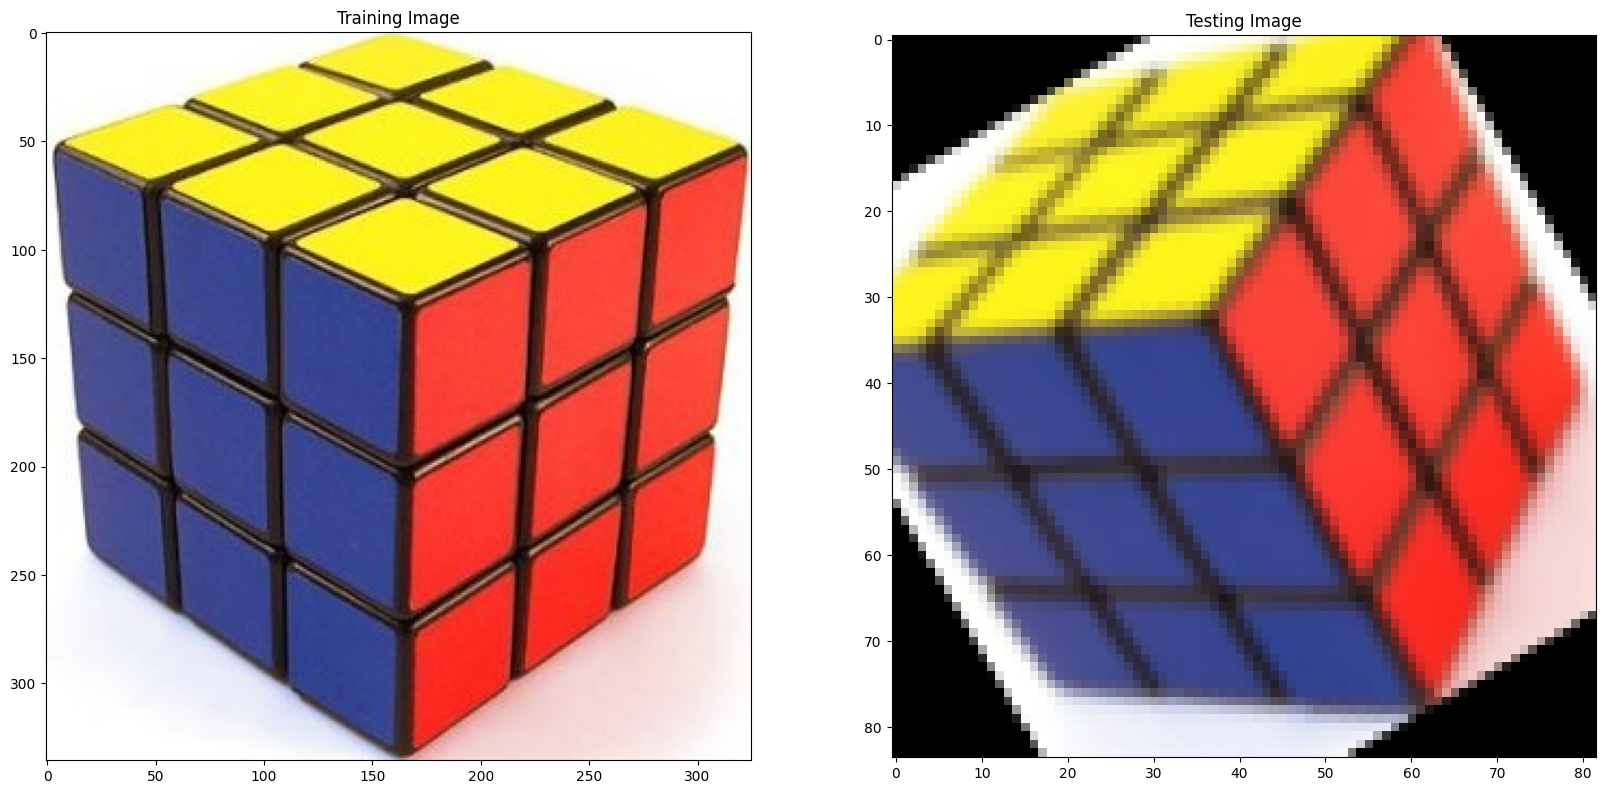

In [ ]:

# Load the image
image1 = cv2.imread('./imgA.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = cv2.pyrDown(training_image)
test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]

rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

Number of Keypoints Detected In The Training Image:  265
Number of Keypoints Detected In The Query Image:  113


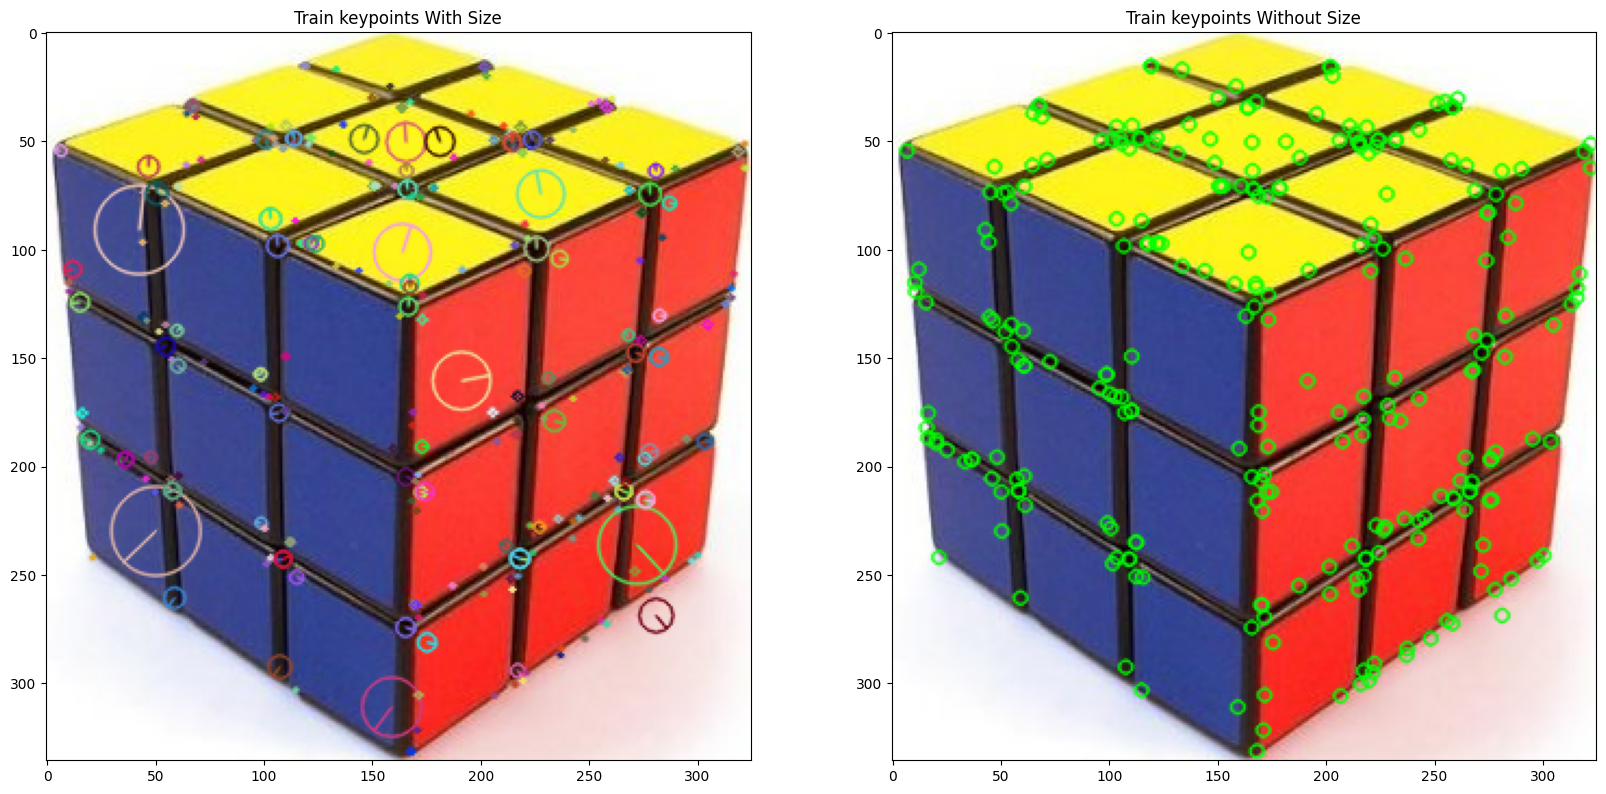

In [ ]:
# Detect keypoints and Create Descriptor
sift = cv2.xfeatures2d.SIFT_create()

train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

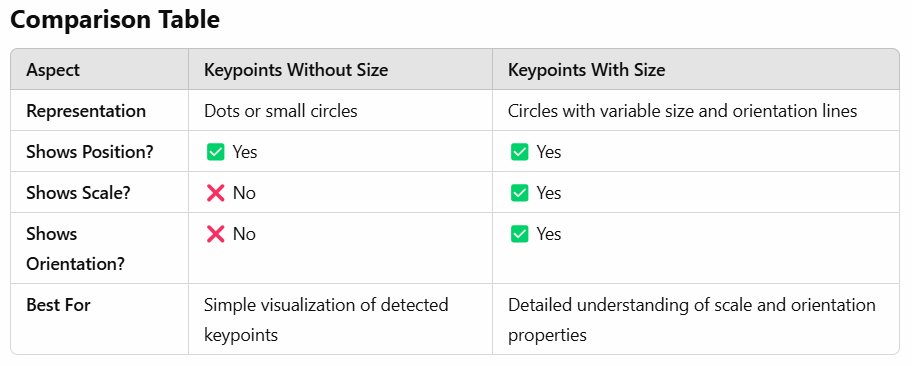

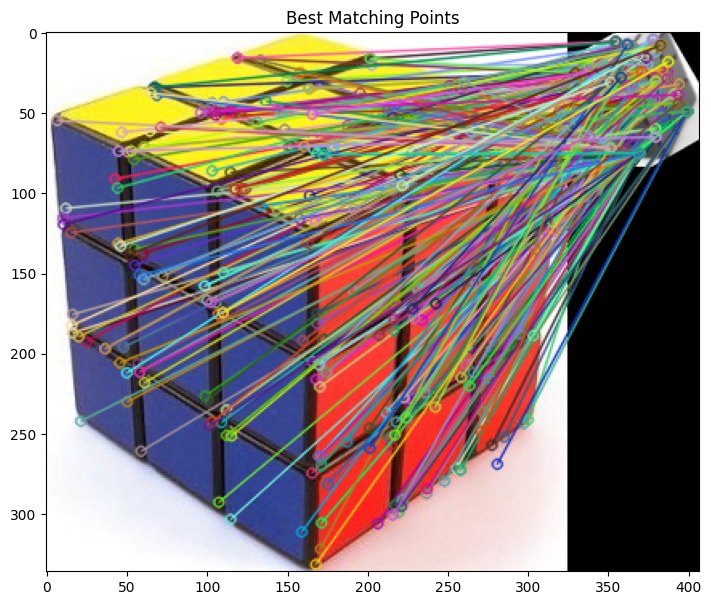


Number of Matching Keypoints Between The Training and Query Images:  265


In [ ]:
# Matching Keypoints

# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

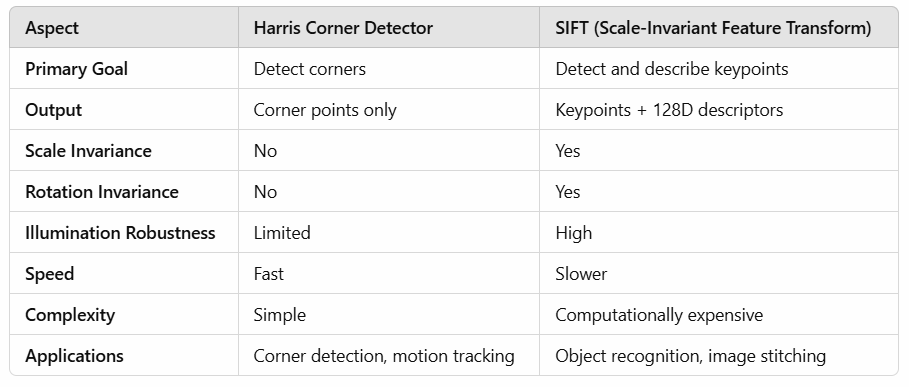

# How to run a sequential model?

**Step 1: Preprocess with Harris Corner Detection**

We will use OpenCV to apply Harris corner detection, and then use the output as an input to the CNN model.

Your X_train and y_train for training the model, you need to follow these steps:

1. Prepare your dataset: Collect a set of images that contain different scenes or objects.

2. Apply Harris Corner Detection: For each image in your dataset, apply Harris corner detection to identify the corners. This will be your X_train, as each image will be transformed into a corner-detected version.

3. Label the images: Label each image as either containing corners or not, or you could annotate the specific corner locations if you want to work with more specific corner detection. For a binary classification, you could label the images as:
  - 1 if the image contains corners
  - 0 if the image does not contain corners (or is a non-corner region)

 These labels will be your y_train.



In [ ]:
def harris_corner_detection(image, block_size=2, ksize=3, k=0.04):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, block_size, ksize, k)
    dst = cv2.dilate(dst, None)
    corners = np.zeros_like(image)
    corners[dst > 0.01 * dst.max()] = [0, 0, 255]  # Mark corners in red
    return corners

In [ ]:
# Prepare X_train by applying Harris Corner Detection to a directory of images
X_train = []
y_train = []

image_list = [f'image({i}).jpg' for i in range(1, 6)]

for image_name in image_list:
    if image_name.endswith('.jpg') or image_name.endswith('.png'):  # Filter image files
        image = cv2.imread(image_name)

        # Apply Harris corner detection
        corner_image = harris_corner_detection(image)

        # Add the corner image to X_train
        X_train.append(corner_image)

        # Label the image as 1 for corner detection (since Harris will always detect corners)
        # You can adjust the logic to create more complex labels
        y_train.append(1)  # For simplicity, labeling as 1 (corner detected)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (5, 256, 256, 3)
y_train shape: (5,)


**Step 2: Define a Sequential CNN Model**

After detecting corners using the Harris method, you can pass this output into a CNN for further classification, detection, or refinement.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
def build_cnn_model(input_shape=(256, 256, 3)):

    model = Sequential()

    # Extracts low-level features (e.g., edges) with 32 filters
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # Reduces spatial dimensions to focus on significant features
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Learns mid-level features (e.g., textures) with 64 filters
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Learns high-level features (e.g., object parts) with 128 filters
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Prepares extracted features for classification
    model.add(Flatten())

    # Combines learned features through a dense layer with 128 neurons
    model.add(Dense(128, activation='relu'))

    # Outputs a single probability for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Configures the model for training
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define the model
model = build_cnn_model()

# Show summary of the model architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,105 (56.61 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

**Step 3: Training the Model**

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7500 - loss: 2.3724 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step - accuracy: 1.0000 - loss

**Step 4: Testing and Evaluation**

In [ ]:
new_image = cv2.imread('test.jpg')
corner_image = harris_corner_detection(new_image)  # Apply Harris Corner detection
corner_image_resized = cv2.resize(corner_image, (256, 256))  # Resize to the correct input size
corner_image_normalized = corner_image_resized / 255.0  # Normalize pixel values

# Reshape for a batch (the model expects a batch of images)
new_image_batch = np.expand_dims(corner_image_normalized, axis=0)

# Predict on the new image
prediction = model.predict(new_image_batch)
print("Prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Prediction: [[1.]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


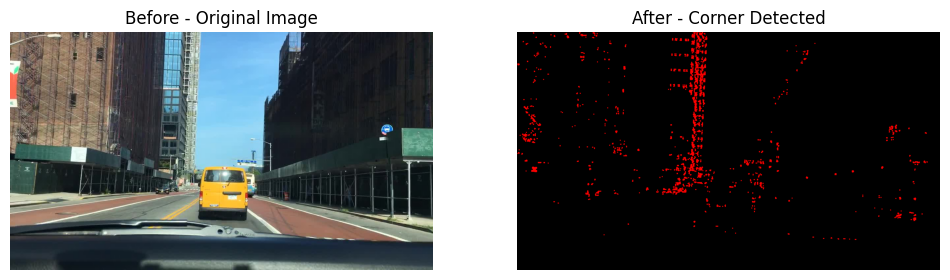

Prediction value: [1.]


In [ ]:
# Load and preprocess the test image
test_image_path = 'test.jpg'
test_image = cv2.imread(test_image_path)

# Apply Harris Corner Detection
corner_image = harris_corner_detection(test_image)

# Resize and normalize the image (resize to the same size as input to your model)
corner_image_resized = cv2.resize(corner_image, (256, 256))  # Ensure the same size as model input
corner_image_normalized = corner_image_resized / 255.0  # Normalize pixel values

# Reshape the image to match the model input (batch size of 1)
test_image_batch = np.expand_dims(corner_image_normalized, axis=0)

# Get the prediction from the model
prediction = model.predict(test_image_batch)

# Convert prediction to class label (assuming binary classification)
prediction_label = 'Corner Detected' if prediction[0] > 0.5 else 'No Corner Detected'

# Display the before and after images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# "Before" image (Original)
axes[0].imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
axes[0].set_title("Before - Original Image")
axes[0].axis('off')  # Hide axes

# "After" image (With Corner Detection)
axes[1].imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
axes[1].set_title(f"After - {prediction_label}")
axes[1].axis('off')  # Hide axes

# Show the plot
plt.show()

# Optionally, display prediction value
print(f"Prediction value: {prediction[0]}")